In [2]:
import xarray as xr
import numpy as np
#import pandas as pd
import os
import glob
import copy as cp
import random
import pyproj as proj
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn import cluster
import wpca
import pandas as pd

from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy as cr
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from datetime import datetime

# parameters

In [3]:
SUB_SETS = {'all':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/Sub_samp_y_1993_-_2014_-delta_1_100000_start_lon_0.nc',\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/'},\
           'weird_path_only':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/WEIRD/Sub_samp_y_1996_-_1997_-delta_1_40000_start_lon_0.nc',\
                  'init_year':1996,\
                  'final_year':1997,\
                   'delta_year':1,\
                  'N_particles':40000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/WEIRD/'},\
           'without_weird_path':{'Subset_name':None,\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/NO_WEIRD/'}}

In [4]:
sel_subset = 'weird_path_only'
load_previous_run = True
init_year = SUB_SETS[sel_subset]['init_year']
final_year = SUB_SETS[sel_subset]['final_year']
delta_year = SUB_SETS[sel_subset]['delta_year']
Subset_name = SUB_SETS[sel_subset]['Subset_name']
N_particles = SUB_SETS[sel_subset]['N_particles']
Subset_path = SUB_SETS[sel_subset]['Subset_path']

files = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_new_*'))
files_m = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_m_200_*'))
length_days = 600
path_save_prediction = Subset_path 


perctest = 0.1 
perctrain = 0.8
trans = True

#PCA 
n_components = 0.999999

# Clustering
init = 'k-means++'
nmb_initialisations = 20  # number of initiatilisaton for the k-means++ 
max_iter = 500
tol = 5e-4
algorithm = 'full'
verbose = 0 
sample_weight = None
n_split = 20  # number of iterations for convergence
n_clusters = 20 #number of clusters

# Generate sub-set

The subset is already generated from the other script. Only apply here

In [5]:
ds_samp = xr.open_dataset(Subset_name)

# Load previous runs 

In [6]:
if load_previous_run:
    Labels_valid = np.load(path_save_prediction+'Labels_valid.npy')
    Labels_test = np.load(path_save_prediction+'Labels_test.npy')
    lats_test = np.load(path_save_prediction+'lats_test.npy')
    lons_test = np.load(path_save_prediction+'lons_test.npy')
    lats_train = np.load(path_save_prediction+'lats_train.npy')
    lons_train = np.load(path_save_prediction+'lons_train.npy')
    lats_valid = np.load(path_save_prediction+'lats_valid.npy')
    lons_valid = np.load(path_save_prediction+'lons_valid.npy')

# Figs

In [7]:
def plot_density_arctic(labs, lons, lats, n_clusters, vmax):
    lims = [-200, -90, 65, 90]
    ncs = np.arange(n_clusters)
    Liste_hist  = []
    f = plt.figure(figsize = (15, 8))   

    for nc in ncs:
        print(nc)

        cf = 'k'

        lons_pdf = [] ; lats_pdf = [] ; count=0
        for n in range(len(labs)):
            if labs[n]==nc :
                lons_pdf.extend(lons[n,:][~np.isnan(lons[n,:])]) ; lats_pdf.extend(lats[n,:][~np.isnan(lats[n,:])])
                count += 1

        # Initalize the histogram
        lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
        x = np.arange(lon1,lon2,1./12.)
        y = np.arange(lat1,lat2,1./12.)

        # Calculate the histogram
        hist, xe, ye = np.histogram2d(lons_pdf, lats_pdf, bins=(x,y))
        hist[hist==0] = np.nan

        # plot
        ax = f.add_subplot(np.max(labs)//6+1,6,nc+1, projection = ccrs.NorthPolarStereo())
        ax.coastlines(color='silver')
        ax.gridlines(zorder=-1)
        ax.set_extent(lims,  crs=ccrs.PlateCarree())
        ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')

        im = ax.pcolor(x, y, hist.T, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
        ##im = ax.pcolor(x, y, hist.T, norm=colors.LogNorm(vmin=2.0,vmax=np.nanpercentile(hist,99)), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
        Liste_hist.append(hist.T)
        ax.text(0.03, 0.05, '#'+str(nc), transform=ax.transAxes, fontsize=16)
        ax.text(0.8, 0.87, str(count), transform=ax.transAxes, fontsize=16)
        #plt.contour(lonb, latb, bathy, [350], colors='dimgrey', transform = ccrs.PlateCarree(), zorder=2)

        if nc==0:
            cbaxes = inset_axes(ax, width="50%", height="5%", loc=3) 
            cbar = plt.colorbar(im, cax=cbaxes, ticks=[0.,10,50], orientation='horizontal')
    return Liste_hist, f

In [8]:
def make_histo_arctic(labs, lons, lats, n_clusters):
    ncs = np.arange(n_clusters)
    Liste_hist  = []
    for nc in ncs:
        print(nc)

        cf = 'k'

        lons_pdf = [] ; lats_pdf = [] ; count=0
        for n in range(len(labs)):
            if labs[n]==nc :
                lons_pdf.extend(lons[n,:][~np.isnan(lons[n,:])]) ; lats_pdf.extend(lats[n,:][~np.isnan(lats[n,:])])
                count += 1

        # Initalize the histogram
        lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
        x = np.arange(lon1,lon2,1./12.)
        y = np.arange(lat1,lat2,1./12.)

        # Calculate the histogram
        hist, xe, ye = np.histogram2d(lons_pdf, lats_pdf, bins=(x,y))
        hist[hist==0] = np.nan
        Liste_hist.append(hist.T)
    return Liste_hist

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


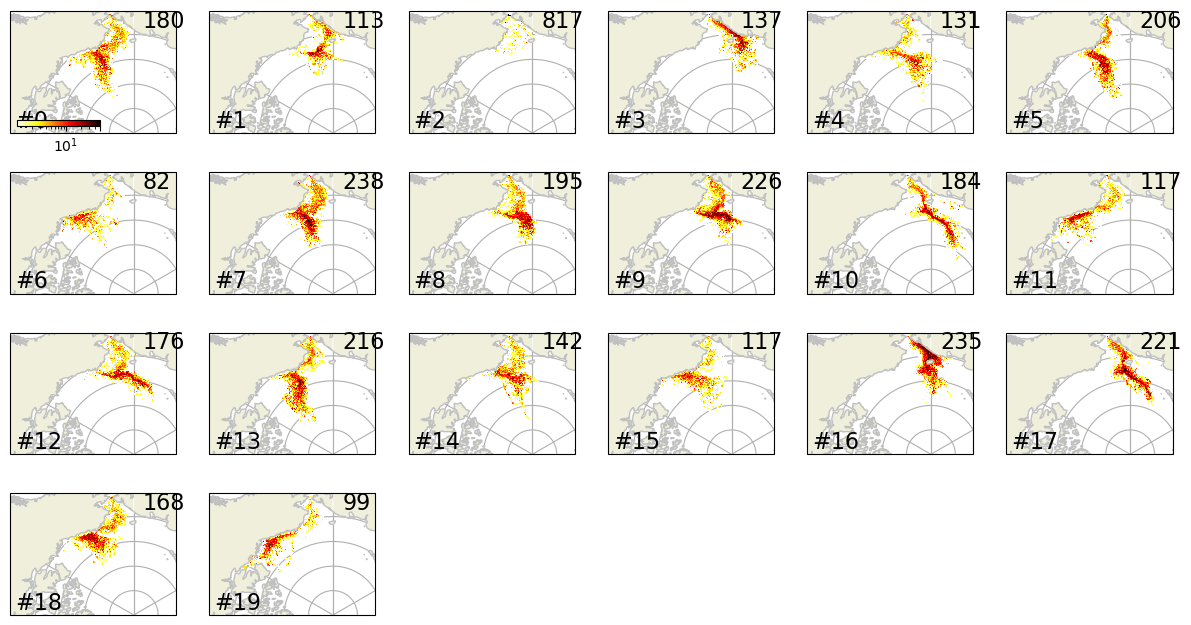

In [9]:
Hist_valid = plot_density_arctic(Labels_valid, lons_valid, lats_valid, n_clusters, vmax = 50)

# PER YEAR : load and save lats-lons

In [17]:
def lons_in_interval(start_lon, lons):
    #this should shift all longitudes so it lies in start_lon + 360. 
    if start_lon<0 : 
        print('start_lons should be in [0-360[')
        return None
    else:
        lons_shifted = lons
        while np.any(lons_shifted<0):
            lons_shifted[lons_shifted<0] = lons_shifted[lons_shifted<0]+360
        lons_2 = cp.copy(lons_shifted)
        lons_2[lons_shifted>=start_lon] = lons_shifted[lons_shifted>=start_lon] - start_lon
        lons_2[lons_shifted<start_lon] = lons_shifted[lons_shifted<start_lon] - start_lon +360
        return cp.copy(lons_2)

In [13]:
def extract(path, length_days) :
    ds = xr.open_dataset(path)
    ds = remove_short(ds)
    lats = ds.lat[:,0:length_days].values
    lons_i = ds.lon[:,0:length_days].values
    lons = lons_in_interval(0, lons_i) # by default start_lon = 360
    temps = ds.temperature[:,0:length_days].values
    sal = ds.salinity[:,0:length_days].values
    z = ds.z[:,0:length_days].values
    date = ds.time[:,0].values
    return lats, lons, temps, sal, date, z

In [10]:
def extract_dates(path, length_days) :
    ds = xr.open_dataset(path)
    ds = remove_short(ds)
    date = ds.time[:,0].values
    return date
def extract_all_dates_year(yr, length_days, all_filles) :
    file = all_filles[np.where(np.array([int(all_filles[i][-7:-3]) for i in range(len(all_filles))]) == yr)[0][0]]
    date = extract_dates(file, length_days)    
    return date

In [15]:
def remove_short(ds): 
    l = [len(ds.sel(traj=i).dropna(dim='obs').obs) for i in ds.traj]
    keep = np.array([i for i in range(len(l)) if l[i] > 90]) # more than 3 months
    ds2 = ds.sel(traj=xr.DataArray(keep)).rename_dims({'dim_0':'traj'}) 
    return ds2

In [11]:
def extract_all_per_year(yr, length_days, all_filles) :
    file = all_filles[np.where(np.array([int(all_filles[i][-7:-3]) for i in range(len(all_filles))]) == yr)[0][0]]
    lats, lons, temps, sal, date, depth = extract(file, length_days)    
    return lats, lons, temps, sal, date, depth

In [18]:
for yr in range(1993,2014):
    print('Year', yr)
    lats_all, lons_all, temps_all, sals_all, date_all, prof_all = extract_all_per_year(yr, length_days, files_m)
    np.save('/storage/nplanat/Glorys12_OP_journalier/lats_lons/m_lats_%i'%yr, lats_all)
    np.save('/storage/nplanat/Glorys12_OP_journalier/lats_lons/m_depths_%i'%yr, prof_all)
    np.save('/storage/nplanat/Glorys12_OP_journalier/lats_lons/m_temps_%i'%yr, temps_all)
    np.save('/storage/nplanat/Glorys12_OP_journalier/lats_lons/m_sals_%i'%yr, sals_all)
    np.save('/storage/nplanat/Glorys12_OP_journalier/lats_lons/m_lons_%i'%yr, lons_all)
    date_all = extract_all_dates_year(yr, length_days, files_m)
    np.save('/storage/nplanat/Glorys12_OP_journalier/lats_lons/m_times_%i'%yr, date_all)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998
Year 1999


IndexError: index 0 is out of bounds for axis 0 with size 0

# Apply all data

In [ ]:
def extract_all_per_year(yr, length_days, all_filles) :
    file = all_filles[np.where(np.array([int(all_filles[i][-7:-3]) for i in range(len(all_filles))]) == yr)[0][0]]
    lats, lons, temps, sal, date, z = extract(file, length_days)    
    return lats, lons, temps, sal, date, z

In [ ]:
def apply_to_all_data_m(Subset_path, init_year,final_year, length_days, files, t, sp):

    for yr in range(init_year,final_year):
        print('Year', yr)
        #lats_all, lons_all, temps_all, sals_all, date_all = extract_all_per_year(yr, length_days, files)
        lats_all = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/m_lats_%i'%yr+'.npy', allow_pickle = True)
        lons_all = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/m_lons_%i'%yr+'.npy', allow_pickle = True)
        labels_all = []
        for sep in range(0,lats_all.shape[0],sp) :
            print(sep,'/',lats_all.shape[0])
            lats_all_l = lats_all[sep:sep+sp,:] ; lons_all_l = lons_all[sep:sep+sp,:]
            
            X_lats_lons_to_classify = Part_1_pre_processing_one_sort(trans, lats_all_l, lons_all_l)
            X_reduced_to_classify = pca.transform(X_lats_lons_to_classify)
            labels = predict(X_reduced_to_classify, Traj_centroids)
            labels_all.extend(labels)
        np.save(Subset_path+'m_labels_data_%i'%yr, labels_all)
        #np.save(Subset_path+'/'+'lats_data_%i'%yr, lats_all)
        #np.save(Subset_path+'/'+'lons_data_%i'%yr, lons_all)
    return None

In [ ]:
apply_to_all_data(path_save_prediction, 1993,2014, length_days, files, trans, sp = 5000)

# Visualize

## All

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


FileNotFoundError: [Errno 2] No such file or directory: '/storage/nplanat/Work_Backuped/GitHub/Clustering_Lagragian_particles/Figures/weird_path_only/Arctic_1993.png'

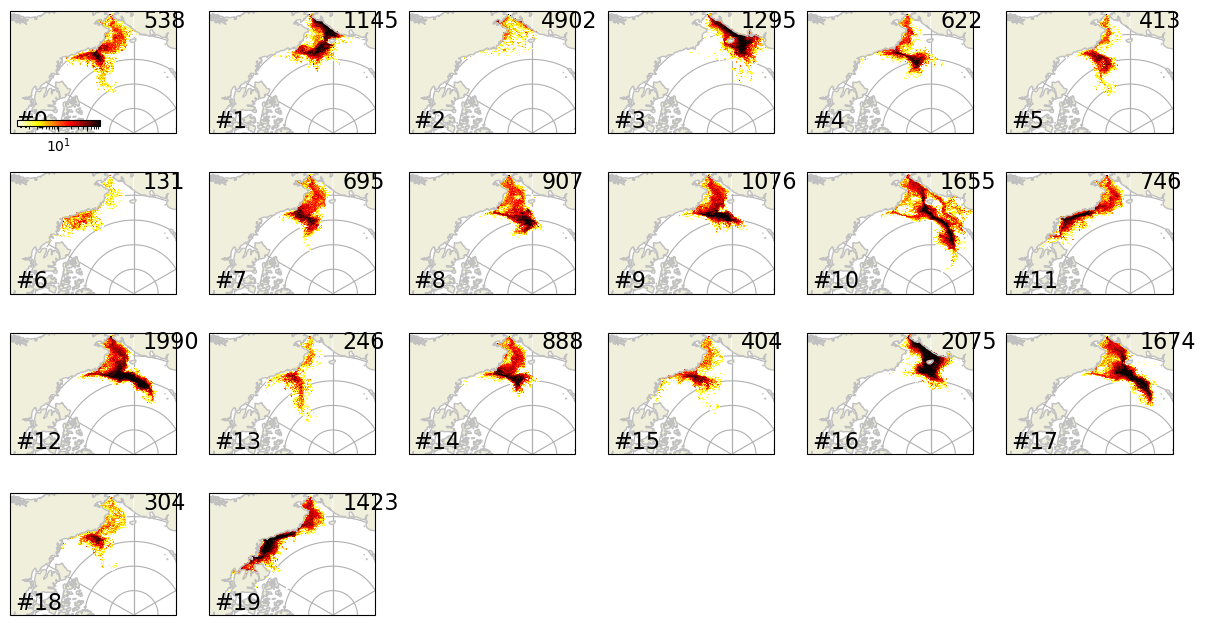

In [49]:
for yr in range(1993, 2014):
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    lats_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'lats_%i'%yr + '.npy', allow_pickle = True)
    lons_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'lons_%i'%yr +'.npy', allow_pickle = True)
    Hist_valid, f = plot_density_arctic(labs_yr, lons_yr, lats_yr, n_clusters, vmax = 100)
    f.savefig('/storage/nplanat/Work_Backuped/GitHub/Clustering_Lagragian_particles/Figures/'+sel_subset+'/Arctic_'+str(yr)+'.png')
    plt.close()

## Groupes

In [33]:
def running_mean(t, x, N) :
    rm = np.convolve(x, np.ones((N,))/N, mode='valid')
    times = t[int(N/2):len(rm)+int(N/2)]
    return times, rm

In [42]:
L1 = [11,19]#ACC
L2 = [10, 12, 16, 17]#Contourne BC
L3 = [3]#eurasie
L4 = [0,5,6,7,13,14,18, 8,9,1,4]# Entre CB
L5 = [2] # Chukchi shelf
#L6 = [8,9,1,4]#NWRidge
Groupes = [L1,L2,L3,L4,L5]#, L6]#,L5,L6]
Names = ['ACC', 'Contourne BC', 'Eurasie', 'Entre CB', 'Chukchi shelf']#, 'NW Ridge']

In [43]:
Dates_all = []; Perc_labels_all = [];
for yr in range(1993,2014):
    print('Year', yr)
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/times_%i'%yr+'.npy', allow_pickle = True)
    Date_data = np.unique(time_yr)
    Dates_all.extend(Date_data)
    Perc_labels = np.zeros((len(Date_data), n_clusters))
    for i in range(len(Date_data)):
        d0 = np.where(Date_data[i] ==time_yr)[0]
        for di in d0:
            Perc_labels[i,labs_yr[di]] +=1
        Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
    Perc_labels_all.extend(Perc_labels)
Perc_labels_all = np.array(Perc_labels_all)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998
Year 1999
Year 2000
Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013


In [44]:
Dates_all_winter = []; Perc_labels_all_winter = [];
for yr in range(1993,2014):
    print('Year', yr)
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/times_%i'%yr+'.npy', allow_pickle = True)
    Date_data = np.unique(time_yr)
    Dates_all_winter.extend(Date_data)
    Perc_labels = np.zeros((len(Date_data), n_clusters))
    M_yr = np.array([pd.Timestamp(time_yr[k]).month for k in range(len(time_yr))])
    for i in range(len(Date_data)):
        d0 = np.where(np.logical_and(Date_data[i] ==time_yr, np.logical_or(M_yr<=3, M_yr==12)))[0]
        for di in d0:
            Perc_labels[i,labs_yr[di]] +=1
        Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
    Perc_labels_all_winter.extend(Perc_labels)
Perc_labels_all_winter = np.array(Perc_labels_all_winter)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998


/tmp/ipykernel_1992710/3639646962.py:14: RuntimeWarning: invalid value encountered in true_divide
  Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)


Year 1999
Year 2000
Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013


In [45]:
Dates_all_winter = []; Perc_labels_all_summer = [];
for yr in range(1993,2014):
    print('Year', yr)
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/times_%i'%yr+'.npy', allow_pickle = True)
    Date_data = np.unique(time_yr)
    Dates_all_winter.extend(Date_data)
    Perc_labels = np.zeros((len(Date_data), n_clusters))
    M_yr = np.array([pd.Timestamp(time_yr[k]).month for k in range(len(time_yr))])
    for i in range(len(Date_data)):
        d0 = np.where(np.logical_and(Date_data[i] ==time_yr, np.logical_and(M_yr>=6, M_yr<=9)))[0]
        for di in d0:
            Perc_labels[i,labs_yr[di]] +=1
        Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
    Perc_labels_all_summer.extend(Perc_labels)
Perc_labels_all_summer = np.array(Perc_labels_all_summer)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998


/tmp/ipykernel_1992710/2984929456.py:14: RuntimeWarning: invalid value encountered in true_divide
  Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)


Year 1999
Year 2000
Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013


In [41]:
vmax = 300

for yr in range(1993, 2014):
    print('year: ', yr)
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    lats_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'lats_%i'%yr + '.npy', allow_pickle = True)
    lons_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'lons_%i'%yr +'.npy', allow_pickle = True) 
    Liste_h = make_histo_arctic(labs_yr, lons_yr, lats_yr, n_clusters)
    f = plt.figure(figsize = (len(Groupes)*4, 8))
    for i in range(len(Groupes)):
        print('groupe, ', i)
        ax = f.add_subplot(2,len(Groupes),i+1)
        ax.plot(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1))
        tm0,rm = running_mean(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1), 53)
        ax.plot(tm0, rm)
        ax.set_ylabel('Population cluster [%]')
        if i == 0:
            ax.text(0.71, 0.87, str(yr), transform=ax.transAxes, fontsize=16)
        ax = f.add_subplot(2,len(Groupes),len(Groupes)+i+1,projection  = ccrs.NorthPolarStereo())
        # Initalize the histogram
        lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
        x = np.arange(lon1,lon2,1./12.)
        y = np.arange(lat1,lat2,1./12.)
        lims = [-200, -90, 65, 90]
        ax.coastlines(color='silver')
        ax.gridlines(zorder=-1)
        ax.set_extent(lims,  crs=ccrs.PlateCarree())
        ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
        A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
        #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
        im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
        ax.set_title(Names[i])
    f.savefig('../Figures_Clustering/Figures/'+sel_subset+'/Arctic_groups_'+str(yr)+'.png', transparent=False)
    plt.close()

year:  1993
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5
year:  1994
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5
year:  1995
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5
year:  1996
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5
year:  1997
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5
year:  1998
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5
year:  1999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5
year:  2000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
groupe,  0
groupe,  1
groupe,  2
groupe,  

## Decomposition series temporelles clusters

groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4


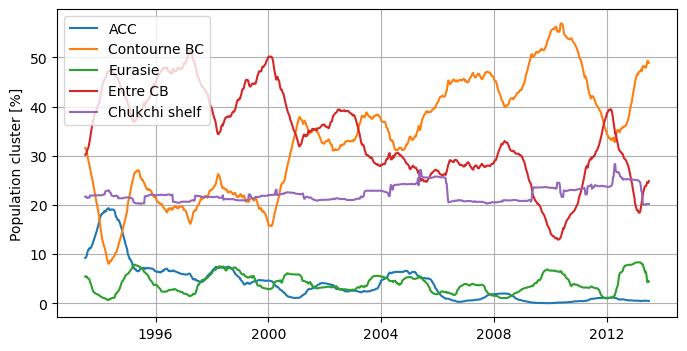

In [46]:
f = plt.figure(figsize = (8,4))
ax = f.add_subplot(1,1,1)
for i in range(len(Groupes)):
    print('groupe, ', i)
    tm0, rm = running_mean(Dates_all, np.nansum(Perc_labels_all[:,Groupes[i]], axis = 1), 53)
    ax.plot(tm0, rm, label = Names[i])
    ax.set_ylabel('Population cluster [%]')
    
ax.grid('on')
ax.legend(loc= 'upper left')

groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4


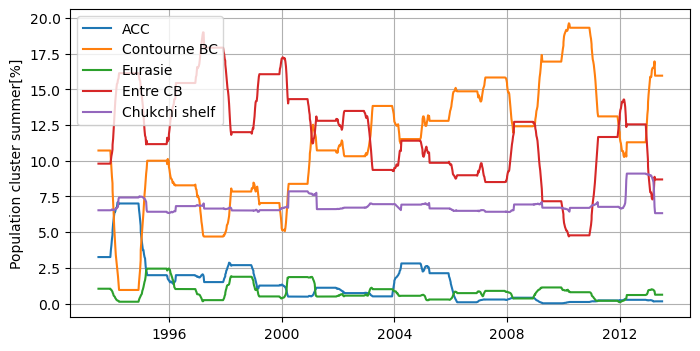

In [47]:
f = plt.figure(figsize = (8,4))
ax = f.add_subplot(1,1,1)
for i in range(len(Groupes)):
    print('groupe, ', i)
    tm0, rm = running_mean(Dates_all, np.nansum(Perc_labels_all_summer[:,Groupes[i]], axis = 1), 53)
    ax.plot(tm0, rm, label = Names[i])
    ax.set_ylabel('Population cluster summer[%]')
    
ax.grid('on')
ax.legend(loc= 'upper left')

groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4


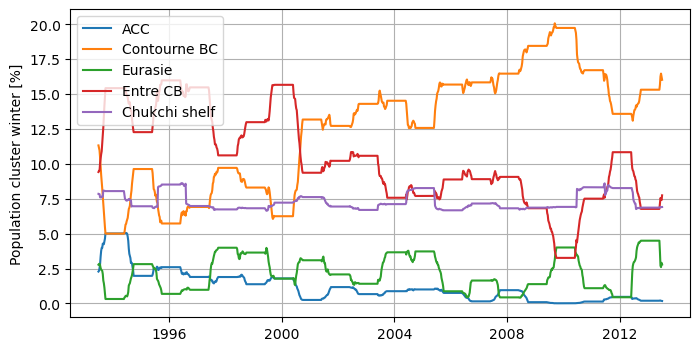

In [48]:
f = plt.figure(figsize = (8,4))
ax = f.add_subplot(1,1,1)
for i in range(len(Groupes)):
    print('groupe, ', i)
    tm0, rm = running_mean(Dates_all, np.nansum(Perc_labels_all_winter[:,Groupes[i]], axis = 1), 53)
    ax.plot(tm0, rm, label = Names[i])
    ax.set_ylabel('Population cluster winter [%]')
    
ax.grid('on')
ax.legend(loc= 'upper left')

In [ ]:
L_ds_G12_all = [xr.open_dataset(x) for x in sorted(glob.glob('/storage/nplanat/Glorys12_ORCA_mensuel/CB_profiles/*'))]
L_times = [datetime.strptime(x[-9:-3], '%Y%m') for x in sorted(glob.glob('/storage/nplanat/Glorys12_ORCA_mensuel/CB_profiles/*'))]
L_maxiT = np.array([x.CT_v.max().values for x in L_ds_G12_all])
L_maxiT_PW = np.array([x.CT_v.isel(z_c = slice(19,25)).max().values for x in L_ds_G12_all])

### Temperatures

In [ ]:
f = plt.figure()
plt.plot(L_times, L_maxiT, label = 'AW')
ax = plt.gca()
plt.plot(L_times, L_maxiT_PW, label = 'sPW')

ax.set_title('max temperature profiles CB G12')
ax.legend()


In [ ]:
f = plt.figure(figsize = (len(Groupes)*4, 10))
ax0 = f.add_subplot(2, len(Groupes), 1)
ax1 = f.add_subplot(2, len(Groupes), 2)
ax2 = f.add_subplot(2, len(Groupes), 3)
ax3 = f.add_subplot(2, len(Groupes), 4)
ax4 = f.add_subplot(2, len(Groupes), 5)
List_ax = [ax0, ax1, ax2, ax3, ax4]
cmap = plt.cm.jet(np.linspace(0,1,21))
for yr in range(1993, 2014):
    print('year: ', yr)
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    temps_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'temps_%i'%yr + '.npy', allow_pickle = True)
    for i in range(len(Groupes)):
        List_ax[i].plot(np.nanmean(temps_yr[np.where(np.array([labs_yr[k] in Groupes[i] for k in range(len(labs_yr))]))[0], :], axis = 0)[1:], c = cmap[yr-1993], label = str(yr))
        #for j in range(len(Groupes[i])):
        #    List_ax[i].plot(np.nanmean(depths_yr[np.where(labs_yr == Groupes[i][j])[0], :], axis = 0))
for ax in List_ax[-1:]:
    #ax.invert_yaxis()
    ax.legend()

            
for i in range(len(Groupes)):
    print('groupe, ', i)
    ax = f.add_subplot(2,len(Groupes),len(Groupes)+i+1,projection  = ccrs.NorthPolarStereo())

    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
    #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    ax.set_title(Names[i])

### Depths

In [ ]:
f = plt.figure(figsize = (len(Groupes)*4, 10))
ax0 = f.add_subplot(2, len(Groupes), 1)
ax1 = f.add_subplot(2, len(Groupes), 2)
ax2 = f.add_subplot(2, len(Groupes), 3)
ax3 = f.add_subplot(2, len(Groupes), 4)
ax4 = f.add_subplot(2, len(Groupes), 5)
List_ax = [ax0, ax1, ax2, ax3, ax4]
cmap = plt.cm.jet(np.linspace(0,1,21))
for yr in range(1993, 2014):
    print('year: ', yr)
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    depths_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'depths_%i'%yr + '.npy', allow_pickle = True)
    for i in range(len(Groupes)):
        List_ax[i].plot(np.nanmean(depths_yr[np.where(np.array([labs_yr[k] in Groupes[i] for k in range(len(labs_yr))]))[0], :], axis = 0), c = cmap[yr-1993], label = str(yr))
        #for j in range(len(Groupes[i])):
        #    List_ax[i].plot(np.nanmean(depths_yr[np.where(labs_yr == Groupes[i][j])[0], :], axis = 0))
for ax in List_ax:
    ax.invert_yaxis()
    ax.set_ylabel('Depth[m]')
    ax.set_xlabel('age [days]')
ax4.legend()

            
for i in range(len(Groupes)):
    print('groupe, ', i)
    ax = f.add_subplot(2,len(Groupes),len(Groupes)+i+1,projection  = ccrs.NorthPolarStereo())

    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
    #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    ax.set_title(Names[i])

### T-depth

In [ ]:
f = plt.figure(figsize = (len(Groupes)*4, 10))
ax0 = f.add_subplot(2, len(Groupes), 1)
ax1 = f.add_subplot(2, len(Groupes), 2)
ax2 = f.add_subplot(2, len(Groupes), 3)
ax3 = f.add_subplot(2, len(Groupes), 4)
ax4 = f.add_subplot(2, len(Groupes), 5)
List_ax = [ax0, ax1, ax2, ax3, ax4]
cmap = plt.cm.jet(np.linspace(0,1,21))
for yr in range(1993, 2014):
    print('year: ', yr)
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    temps_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'temps_%i'%yr + '.npy', allow_pickle = True)
    depths_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'depths_%i'%yr + '.npy', allow_pickle = True)

    for i in range(len(Groupes)):
        T = np.nanmean(temps_yr[np.where(np.array([labs_yr[k] in Groupes[i] for k in range(len(labs_yr))]))[0], :], axis = 0)
        D = np.nanmean(depths_yr[np.where(np.array([labs_yr[k] in Groupes[i] for k in range(len(labs_yr))]))[0], :], axis = 0)
        List_ax[i].plot(T, D, c = cmap[yr-1993], label = str(yr))
        #for j in range(len(Groupes[i])):
        #    List_ax[i].plot(np.nanmean(depths_yr[np.where(labs_yr == Groupes[i][j])[0], :], axis = 0))
for ax in List_ax[-1:]:
    #ax.invert_yaxis()
    ax.legend()
for ax in List_ax:
    ax.set_xlabel(r'T [$^\circ$C]')
    ax.set_ylabel('Depth [m]')
            
for i in range(len(Groupes)):
    print('groupe, ', i)
    ax = f.add_subplot(2,len(Groupes),len(Groupes)+i+1,projection  = ccrs.NorthPolarStereo())

    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
    #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    ax.set_title(Names[i])

### T-S diagrams

In [ ]:
# for isopycnals ---
import seawater.eos80 as sw

In [ ]:
# plot
smin = 27 ; smax = 35
tmin = -2 ; tmax=0



dens = np.zeros((ydim,xdim))
ti = np.linspace(tmin,tmax+1,50)
si = np.linspace(smin,smax+1,50)
TT, SS = np.meshgrid(ti, si)
Sig0 = sw.dens0(TT, SS)

In [ ]:
s_all = [[0] for k in range(len(Groupes))]
t_all = [[0] for k in range(len(Groupes))]
d_all = [[0] for k in range(len(Groupes))]
for i in range(len(Groupes)):
    print(i)
    si = []
    ti = []
    di = []
    for yr in range(1993, 2014):
        labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
        temps_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'temps_%i'%yr + '.npy', allow_pickle = True)
        sals_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'sals_%i'%yr + '.npy', allow_pickle = True)   
        dates_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/times_%i'%yr+ '.npy', allow_pickle = True)   
        dates_yr = np.repeat(dates_yr[:, np.newaxis], 600, axis = -1)
        T = temps_yr[np.where(np.array([labs_yr[k] in Groupes[i] for k in range(len(labs_yr))]))[0], :]
        t = T.reshape(T.shape[0]*T.shape[1])
        t[t==0] = np.nan        
        D = dates_yr[np.where(np.array([labs_yr[k] in Groupes[i] for k in range(len(labs_yr))]))[0], :]
        d = D.reshape(T.shape[0]*T.shape[1])
        #d[t==0] = np.nan  
        S = sals_yr[np.where(np.array([labs_yr[k] in Groupes[i] for k in range(len(labs_yr))]))[0], :]
        s = S.reshape(T.shape[0]*T.shape[1])
        s[s==0] = np.nan  
        si.extend(s)
        ti.extend(t)
        di.extend(d)
    s_all[i] = si
    t_all[i] = ti
    d_all[i] = di

In [ ]:
f = plt.figure(figsize = (15, 10))
cmap = plt.cm.magma_r
for i in range(len(Groupes)):
    ax = f.add_subplot(2, len(Groupes), i+1)
    h =ax.hist2d(s_all[i], t_all[i], bins = 80, range = [[smin, smax], [tmin, tmax]], density=True, cmap = cmap, vmin = 0.001, vmax = 1)
    ax.set_title(Names[i])
    ax.set_ylabel(r'T [$^\circ$C]')
    ax.set_xlabel('S [psu]')
    #im = ax.contour(TT, SS, Sig0, levels = np.arange(1024, 1028))
    
    
for i in range(len(Groupes)):
    print('groupe, ', i)
    ax = f.add_subplot(2, len(Groupes), 6+i,projection  = ccrs.NorthPolarStereo())

    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
    #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    ax.set_title(Names[i])

In [ ]:
f = plt.figure(figsize = (len(Groupes)*7, 30))
cmap = plt.cm.magma_r

for yr in range(1993, 2014):
    print('year: ', yr)
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    temps_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'temps_%i'%yr + '.npy', allow_pickle = True)
    sals_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'sals_%i'%yr + '.npy', allow_pickle = True)   
    for i in range(len(Groupes)):
        ax = f.add_subplot(22, 5, (yr-1993)*5+i+1)
        T = temps_yr[np.where(np.array([labs_yr[k] in Groupes[i] for k in range(len(labs_yr))]))[0], :]
        t = T.reshape(T.shape[0]*T.shape[1])
        t[t==0] = np.nan        
        S = sals_yr[np.where(np.array([labs_yr[k] in Groupes[i] for k in range(len(labs_yr))]))[0], :]
        s = S.reshape(T.shape[0]*T.shape[1])
        s[s==0] = np.nan  
        h =ax.hist2d(s, t, bins = 80, range = [[smin, smax], [tmin, tmax]], density=True, cmap = cmap, vmin = 0.001, vmax = 0.4)
        ax.set_title('yr')
        ax.set_ylabel(r'T [$^\circ$C]')
        ax.set_xlabel('S [psu]')
    #im = ax.contour(TT, SS, Sig0, levels = np.arange(1024, 1028))
            
for i in range(len(Groupes)):
    print('groupe, ', i)
    ax = f.add_subplot(22, 5,106+i,projection  = ccrs.NorthPolarStereo())

    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
    #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    ax.set_title(Names[i])

## Seasonality

In [ ]:
f = plt.figure(figsize = (8,4))
ax = f.add_subplot(1,1,1)
for i in range(len(Groupes)):
    print('groupe, ', i)
    X = np.nansum(Perc_labels_all_winter[:,Groupes[i]], axis = 1)
    YR = np.arange(1993, 2014)
    YR[0] = np.nanmean(X[:18])
    YR[1] = np.nanmean(X[18:36])
    YR[2] = np.nanmean(X[36:54])
    YR[3] = np.nanmean(X[54:72])
    YR[4] = np.nanmean(X[72:90])
    YR[5] = np.nanmean(X[90:108])
    YR[6] = np.nanmean(X[108:126])
    YR[7] = np.nanmean(X[18:36])
    YR[8] = np.nanmean(X[18:36])
    YR[9] = np.nanmean(X[18:36])
    YR[10] = np.nanmean(X[18:36])
    YR[11] = np.nanmean(X[18:36])
    YR[12] = np.nanmean(X[18:36])
    YR[13] = np.nanmean(X[18:36])
    YR[14] = np.nanmean(X[18:36])
    YR[15] = np.nanmean(X[18:36])
    YR[16] = np.nanmean(X[18:36])
    YR[17] = np.nanmean(X[18:36])
    YR[18] = np.nanmean(X[18:36])
    YR[19] = np.nanmean(X[18:36])
    YR[20] = np.nanmean(X[18:36])
    YR[14] = np.nanmean(X[18:36])
    Dates = [Dates_all_winter[x] for x in np.where(X>0)[0].astype(int)]
    Yr = np.array([pd.Timestamp(Dates[x]).month for x range len(Dates)])
    tm0, rm = running_mean(Dates[np.logical_or(Mr==12, Mr <=3)],X[np.where(X>0)[0].astype(int)], 53)
    ax.plot(tm0, rm, label = Names[i])
    ax.set_ylabel('Population cluster [%]')
ax.grid('on')
ax.legend(loc= 'upper left')